In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import torch

from src.download import MOEXCandlesFetcher
from src.baseline import BaselineBacktest
from src.anomaly_detector import AnomalyDetector
from src.signal_classifier import SignalClassifier
from src.lstm_forecast import LSTMForecaster

from src.prepare_dataloaders import prepare_dataloaders

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
TICKERS = ["YNDX", "YDEX", "FIVE", "X5", "LKOH", "MGNT", "ABRD", "GAZP", "SBER", "CHMF"]

data_path = "./data/moex_data_test.csv"
fetcher = MOEXCandlesFetcher()
df = fetcher.run(data_path=data_path, tickers=TICKERS, from_date="2015-01-01")

Загружены ранее скачанные данные ./data/moex_data_test.csv.


In [4]:
df.isna().sum()

ticker      0
date        0
open      633
low       633
high      633
close     633
volume      0
dtype: int64

In [5]:
data = df.ffill().bfill()
data.isna().sum()

ticker    0
date      0
open      0
low       0
high      0
close     0
volume    0
dtype: int64

In [6]:
fig_close_prices = px.line(
    data,
    x="date",
    y="close",
    color="ticker",
    title="Цена закрытия по каждому тикеру",
    labels={"date": "Дата", "close": "Цена закрытия", "ticker": "Тикер"})

fig_close_prices.show()

In [7]:
baseline_backtester = BaselineBacktest(data)
baseline_portfolio = baseline_backtester.run_backtest(init_cash=100_000)
baseline_metrics = baseline_backtester.get_metrics(tickers=data.ticker.unique())

In [8]:
baseline_metrics

{'ABRD': {'Sharpe Ratio': 0.3560890852457661,
  'Sortino Ratio': 0.6096497384127894,
  'Max Drawdown': 59.43060498220641},
 'CHMF': {'Sharpe Ratio': 0.3584276960517146,
  'Sortino Ratio': 0.4958418523870438,
  'Max Drawdown': 69.5619817137997},
 'GAZP': {'Sharpe Ratio': 0.14547128919049654,
  'Sortino Ratio': 0.20362617914359127,
  'Max Drawdown': 72.51038941049715},
 'LKOH': {'Sharpe Ratio': 0.47644060112819536,
  'Sortino Ratio': 0.6752434065174251,
  'Max Drawdown': 52.4356648525163},
 'MGNT': {'Sharpe Ratio': -0.07273858721498828,
  'Sortino Ratio': -0.0998702401529861,
  'Max Drawdown': 81.76782649399283},
 'SBER': {'Sharpe Ratio': 0.638265700825996,
  'Sortino Ratio': 0.8697259140758818,
  'Max Drawdown': 73.81320949432404},
 'X5': {'Sharpe Ratio': 0.28810619786350494,
  'Sortino Ratio': 0.41052865045345216,
  'Max Drawdown': 74.86373837768515},
 'YDEX': {'Sharpe Ratio': 0.5262232716437696,
  'Sortino Ratio': 0.7325884076474591,
  'Max Drawdown': 77.50365200454472}}

In [9]:
custom_params = {
    "n_estimators": 500,
    "contamination": 0.2,
    "n_jobs": -1,
    "random_state": 42,
    }

anomaly_detector = AnomalyDetector(df=data, model_params=custom_params)
extended_df, features = anomaly_detector.generate_features()

In [10]:
df_with_anomalies = anomaly_detector.detect_anomalies()
df_with_anomalies

,ticker,date,open,low,high,close,volume,return,amplitude,anomaly
0,ABRD,2015-01-05,99.0,99.0,99.0,99.0,0,0.000000,0.000000,0
1,ABRD,2015-01-06,99.0,99.0,99.0,99.0,0,0.000000,0.000000,0
2,ABRD,2015-01-08,99.0,99.0,99.0,99.0,100,0.000000,0.000000,0
3,ABRD,2015-01-09,90.0,90.0,90.0,90.0,100,-0.090909,0.000000,1
4,ABRD,2015-01-12,88.0,88.0,90.0,90.0,200,0.000000,0.022727,0
...,...,...,...,...,...,...,...,...,...,...
19943,YDEX,2025-04-02,4348.0,4343.5,4435.0,4409.0,737581,0.012283,0.021066,0
19944,YDEX,2025-04-03,4416.0,4211.0,4434.0,4291.0,859790,-0.026763,0.052957,1
19945,YDEX,2025-04-04,4295.0,4067.0,4313.0,4088.0,1439457,-0.047308,0.060487,1
19946,YDEX,2025-04-07,4075.0,3901.0,4368.0,4069.0,2868717,-0.004648,0.119713,1


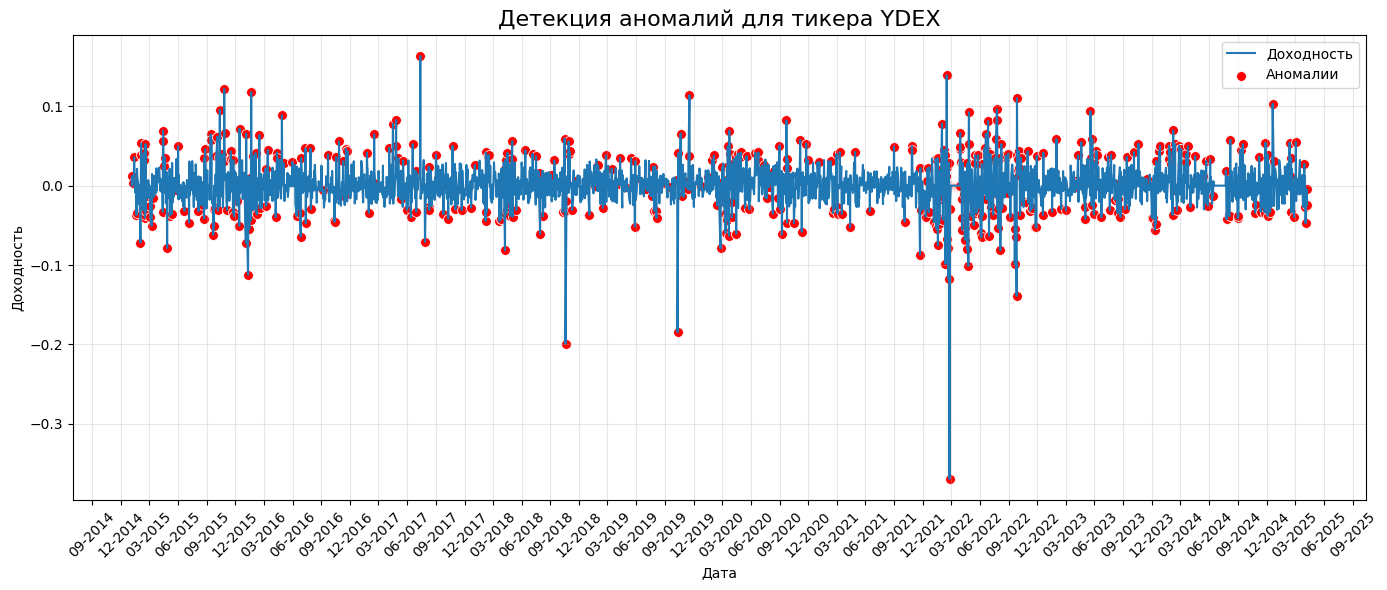

In [11]:
anomaly_detector.visualize_anomalies(ticker="YDEX", is_interactive=False)

In [12]:
df_with_anomalies.corr(numeric_only=True)

,open,low,high,close,volume,return,amplitude,anomaly
open,1.000000,0.999788,0.999762,0.999676,-0.318665,-0.013763,-0.035045,-0.020611
low,0.999788,1.000000,0.999633,0.999831,-0.318705,-0.005175,-0.042638,-0.025467
high,0.999762,0.999633,1.000000,0.999792,-0.318886,-0.007191,-0.026387,-0.014184
close,0.999676,0.999831,0.999792,1.000000,-0.318757,0.000178,-0.035984,-0.019814
volume,-0.318665,-0.318705,-0.318886,-0.318757,1.000000,-0.020990,0.141957,0.156087
return,-0.013763,-0.005175,-0.007191,0.000178,-0.020990,1.000000,-0.096812,0.028333
amplitude,-0.035045,-0.042638,-0.026387,-0.035984,0.141957,-0.096812,1.000000,0.496054
anomaly,-0.020611,-0.025467,-0.014184,-0.019814,0.156087,0.028333,0.496054,1.000000


In [13]:
gen_features = [
    "sma_3", "sma_5", "sma_7", "sma_10", 
    "ema_3", "ema_5", "ema_7", "ema_10", 
    "rsi_7", "rsi_14", "rsi_28", 
    "atr_7", "atr_14", "atr_28", 
    "volume_ratio_10", "volume_ratio_20", "volume_ratio_30", 
    "amplitude_mean_10", "amplitude_mean_20", "amplitude_mean_30", 
    "return_lag_3", "return_lag_5", "return_lag_7", "return_lag_10"
    ]

In [14]:
signal_classifier = SignalClassifier(df_with_anomalies, features=gen_features, lookahead=3)

In [15]:
signal_classifier.train(train_period_end="2024-08-31", eval_period_end="2025-01-31")

0:	learn: 0.6901256	test: 0.6926745	best: 0.6926745 (0)	total: 198ms	remaining: 1m 39s
100:	learn: 0.5785493	test: 0.6758891	best: 0.6758891 (100)	total: 2.85s	remaining: 11.3s
200:	learn: 0.5048379	test: 0.6716733	best: 0.6706589 (152)	total: 5.56s	remaining: 8.28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6706588848
bestIteration = 152

Shrink model to first 153 iterations.
Модель успешно обучена!


In [16]:
signal_classifier.feature_importance().head()

,Feature Id,Importances
0,amplitude_mean_20,7.578522
1,amplitude,7.257100
2,volume_ratio_10,6.081776
3,return_lag_5,5.471040
4,return_lag_7,5.117470


In [17]:
signal_portfolio = signal_classifier.run_backtest(init_cash=100_000)
signal_metrics = signal_classifier.get_metrics(df_with_anomalies.ticker.unique())

signal_metrics

{'ABRD': {'Sharpe Ratio': -0.3116845567467496,
  'Sortino Ratio': -0.3116845567467498,
  'Max Drawdown': 5.267629566694988},
 'CHMF': {'Sharpe Ratio': -0.5721664029591396,
  'Sortino Ratio': -0.6384478976821594,
  'Max Drawdown': 22.31344218092635},
 'GAZP': {'Sharpe Ratio': -0.2320985220929118,
  'Sortino Ratio': -0.29264424602070943,
  'Max Drawdown': 19.10494553098493},
 'LKOH': {'Sharpe Ratio': -0.3776971483539388,
  'Sortino Ratio': -0.4444725649335601,
  'Max Drawdown': 10.227382265474324},
 'MGNT': {'Sharpe Ratio': -0.04430025096045089,
  'Sortino Ratio': -0.08597104058550172,
  'Max Drawdown': 4.298526513481626},
 'SBER': {'Sharpe Ratio': -0.17694908161276288,
  'Sortino Ratio': -0.20173898226702935,
  'Max Drawdown': 5.541394948525276},
 'X5': {'Sharpe Ratio': -0.5933451374337417,
  'Sortino Ratio': -0.5930452650864683,
  'Max Drawdown': 6.557242120055569},
 'YDEX': {'Sharpe Ratio': -0.14809098545894045,
  'Sortino Ratio': -0.19528060155161642,
  'Max Drawdown': 5.857160668246

In [18]:
lstm_df = df.pivot(index="date", columns="ticker", values="close")
lstm_df = lstm_df.ffill().bfill()
lstm_df.head()

ticker,ABRD,CHMF,GAZP,LKOH,MGNT,SBER,X5,YDEX
date,,,,,,,,
2015-01-05,99.0,522.00,133.95,2295.0,9877.0,56.37,2110.0,1079.0
2015-01-06,99.0,556.90,138.92,2345.0,10400.0,58.28,2110.0,1092.0
2015-01-08,99.0,542.70,146.46,2572.0,10627.0,65.70,2110.0,1094.0
2015-01-09,90.0,548.55,141.70,2461.0,10542.0,63.10,2110.0,1098.0
2015-01-12,90.0,558.45,140.22,2477.0,10689.0,62.90,2110.0,1113.0


In [19]:
lstm_returns = lstm_df.pct_change().fillna(0)
lstm_returns.head()

ticker,ABRD,CHMF,GAZP,LKOH,MGNT,SBER,X5,YDEX
date,,,,,,,,
2015-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2015-01-06,0.000000,0.066858,0.037103,0.021786,0.052951,0.033883,0.0,0.012048
2015-01-08,0.000000,-0.025498,0.054276,0.096802,0.021827,0.127316,0.0,0.001832
2015-01-09,-0.090909,0.010779,-0.032500,-0.043157,-0.007998,-0.039574,0.0,0.003656
2015-01-12,0.000000,0.018048,-0.010445,0.006501,0.013944,-0.003170,0.0,0.013661


In [20]:
lstm_returns.describe().loc[["min", "max"]]

ticker,ABRD,CHMF,GAZP,LKOH,MGNT,SBER,X5,YDEX
min,-0.229730,-0.221087,-0.304552,-0.227575,-0.280000,-0.366134,-0.261047,-0.369215
max,0.398467,0.114412,0.249510,0.154235,0.131992,0.128986,0.130247,0.163297


In [21]:
fig_returns = go.Figure()

DAYS = 50

for ticker in lstm_returns.columns:
    fig_returns.add_trace(go.Scatter(x=lstm_returns.index[-DAYS:], y=lstm_returns[ticker][-DAYS:], mode="lines", name=f"{ticker}"))

fig_returns.update_layout(title=f"Доходность по каждому тикеру за последние {DAYS} торговых дней", xaxis_title="Дата", yaxis_title="Доходность")
fig_returns.show()

In [22]:
naive_forecast, naive_metrics, naive_train, naive_test = baseline_backtester.seasonal_naive_forecast(
    returns=lstm_returns,
    train_ratio=0.9,
    season_length=7
    )

In [23]:
import random

rand_ticker = random.choice(naive_train.columns)
naive_fig = go.Figure([
    go.Scatter(x=naive_train.index[-20:],y=naive_train[rand_ticker].iloc[-20:],mode="lines", name="Трейн последние 20 точек", line=dict(color="orange")),
    go.Scatter(x=naive_train.index[-7:],y=naive_train[rand_ticker].iloc[-7:],mode="lines+markers", name="Трейн последние 7 точек", line=dict(color="red")),
    go.Scatter(x=naive_test.index, y=naive_test[rand_ticker], mode="lines", name="Тест", line=dict(color="green")),
    go.Scatter(x=naive_forecast.index, y=naive_forecast[rand_ticker], mode="lines", name="Наивный прогноз", line=dict(color="blue"))
])

naive_fig.update_layout(title=f"Наивный прогноз для тикера {rand_ticker}", xaxis_title="Дата", yaxis_title="Доходность")
naive_fig.show()

In [24]:
cov_window = 60
rolling_covs = lstm_returns.rolling(window=cov_window).cov(pairwise=True).ffill().bfill()
rolling_covs.head()

ticker                 ABRD      CHMF      GAZP      LKOH     MGNT      SBER  \
date       ticker                                                              
2015-01-05 ABRD    0.002188 -0.000096 -0.000098 -0.000161  0.00002 -0.000111   
           CHMF    0.002188 -0.000096 -0.000098 -0.000161  0.00002 -0.000111   
           GAZP    0.002188 -0.000096 -0.000098 -0.000161  0.00002 -0.000111   
           LKOH    0.002188 -0.000096 -0.000098 -0.000161  0.00002 -0.000111   
           MGNT    0.002188 -0.000096 -0.000098 -0.000161  0.00002 -0.000111   

ticker              X5     YDEX  
date       ticker                
2015-01-05 ABRD    0.0  0.00013  
           CHMF    0.0  0.00013  
           GAZP    0.0  0.00013  
           LKOH    0.0  0.00013  
           MGNT    0.0  0.00013

In [25]:
rolling_covs.describe().loc[["min", "max"]]

ticker,ABRD,CHMF,GAZP,LKOH,MGNT,SBER,X5,YDEX
min,-0.000290,-0.000207,-0.000231,-0.000247,-0.000249,-0.000290,-0.000168,-0.000268
max,0.006204,0.002372,0.003423,0.002637,0.003101,0.004331,0.003182,0.004199


In [26]:
dataloaders = prepare_dataloaders(returns=lstm_returns, rolling_covs=rolling_covs, seq_len=60, forecast_horizon=7, batch_size=128)
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x25a827d4290>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x25a83b90950>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x25a83b8aa90>}

In [27]:
train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

In [28]:
model = LSTMForecaster(num_tickers=8, cov_embed_dim=8, hidden_dim=64, num_layers=1, forecast_horizon=7)
results = model.fit(train_loader=train_loader, val_loader=val_loader, num_epochs=20, patience=5, verbose=True)

Эпоха 1: [train_loss] = 0.002225 | [val_loss] = 0.000794
Эпоха 2: [train_loss] = 0.000746 | [val_loss] = 0.000625
Эпоха 3: [train_loss] = 0.000630 | [val_loss] = 0.000602
Эпоха 4: [train_loss] = 0.000592 | [val_loss] = 0.000600
Эпоха 5: [train_loss] = 0.000575 | [val_loss] = 0.000597
Эпоха 6: [train_loss] = 0.000566 | [val_loss] = 0.000597
Эпоха 7: [train_loss] = 0.000556 | [val_loss] = 0.000596
Эпоха 8: [train_loss] = 0.000549 | [val_loss] = 0.000596
Эпоха 9: [train_loss] = 0.000546 | [val_loss] = 0.000596
Эпоха 10: [train_loss] = 0.000544 | [val_loss] = 0.000596
Эпоха 11: [train_loss] = 0.000541 | [val_loss] = 0.000597
Эпоха 12: [train_loss] = 0.000538 | [val_loss] = 0.000596
Сработала ранняя остановка.


In [29]:
predictions, targets = model.predict_dataset(test_loader)

In [30]:
test_metrics = model.evaluate_model(test_loader)
test_metrics

{'MAE': 0.012992646, 'RMSE': 0.019476268}

In [31]:
naive_metrics

{'MAE': 0.022456576160203415, 'RMSE': 0.032086179118856105}

In [32]:
df_last, df_forecast, df_combined = LSTMForecaster.create_forecast_dfs(lstm_returns, predictions, last_n=20)

In [33]:
df_forecast

ticker,ABRD,CHMF,GAZP,LKOH,MGNT,SBER,X5,YDEX
2025-04-09,0.000191,0.001040,0.000496,0.000643,-0.000502,-0.000170,0.000592,0.000766
2025-04-10,0.000766,0.000275,0.000036,0.000468,-0.000445,0.000579,0.000622,0.001651
2025-04-11,0.000832,-0.000955,0.001026,-0.000339,-0.000615,0.000338,0.000545,0.000812
2025-04-14,0.000825,0.001411,-0.000849,0.000639,0.000037,0.000076,0.000513,0.000311
2025-04-15,0.001648,0.000389,-0.000506,0.001899,0.000131,0.000511,0.000189,0.002040
2025-04-16,0.000627,0.000677,0.000065,-0.000671,-0.000156,0.000767,0.000028,-0.000906
2025-04-17,0.000288,0.000473,-0.001874,0.001192,-0.000971,0.001619,0.002418,0.000509


In [34]:
all_dfs = pd.concat([lstm_returns, df_forecast])
all_dfs.tail(10)

ticker,ABRD,CHMF,GAZP,LKOH,MGNT,SBER,X5,YDEX
2025-04-04,-0.065083,-0.036357,-0.058273,-0.052411,-0.052061,-0.055414,-0.030896,-0.047308
2025-04-07,-0.019890,-0.025892,-0.008919,-0.014894,-0.004643,0.007745,-0.006006,-0.004648
2025-04-08,0.034949,-0.057528,-0.029147,-0.010395,-0.011377,-0.019231,-0.005423,-0.024453
2025-04-09,0.000191,0.001040,0.000496,0.000643,-0.000502,-0.000170,0.000592,0.000766
2025-04-10,0.000766,0.000275,0.000036,0.000468,-0.000445,0.000579,0.000622,0.001651
2025-04-11,0.000832,-0.000955,0.001026,-0.000339,-0.000615,0.000338,0.000545,0.000812
2025-04-14,0.000825,0.001411,-0.000849,0.000639,0.000037,0.000076,0.000513,0.000311
2025-04-15,0.001648,0.000389,-0.000506,0.001899,0.000131,0.000511,0.000189,0.002040
2025-04-16,0.000627,0.000677,0.000065,-0.000671,-0.000156,0.000767,0.000028,-0.000906
2025-04-17,0.000288,0.000473,-0.001874,0.001192,-0.000971,0.001619,0.002418,0.000509
